# Hydrologi

Me skal analysera vassføringsdata lasta ned frå sildre.nve.no. 
Arbeidet her er basert på data frå Reinsnos målestasjon, som har data tilbake til 1917. 

Me startar med å importera biblioteka me skal bruka:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Vidare skal me importera datamaterialet til ei dataramme (dataframe, "df") og rydda i den. 

In [2]:
df = pd.read_csv(
    "vassføring_reinsnos.csv", sep = ";", skiprows = 2, 
    names = ["dato", "Vassføring", "Korrigert", "Kontrollert"], parse_dates = True, decimal=",")

df.index = pd.to_datetime(df['dato']) 
df.index = df.index.date
df = df.drop(columns = ["dato", "Korrigert", "Kontrollert"])

df.index = pd.to_datetime(df.index)

Skriv ut dei fem første linjene for å sjekka at det ser greit ut. 

In [3]:
df.tail()

,Vassføring
2022-03-15,0.886099
2022-03-16,0.844773
2022-03-17,0.815767
2022-03-18,0.852932
2022-03-19,0.836391


## Middelflom

Middelflommen til ei elv er rekna ut frå den største døgnvassføringa per år over eit lengre tidsrom. Frå [NVE](https://www.nve.no/naturfare/laer-om-naturfare/hva-er-flom/) finn me denne definisjonen:

> En middelflom (normal flom) defineres som gjennomsnittet av høyeste vannføring hvert år i en lang årrekke.

For å rekna ut dette må me altså først finna den maksimale vassføringa per år. Bruker `groupby` i Pandas for å finne dette. 

In [4]:
årleg_maks = df.groupby(by=[df.index.year]).max()

Plottar den nye dataramma for å sjå korleis dette ser ut:

<AxesSubplot:>

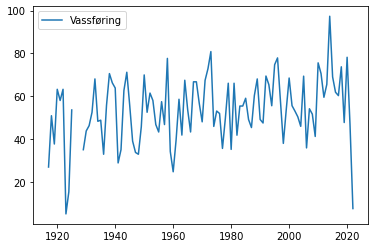

In [5]:
årleg_maks.plot()

Ser at det er eit hol rundt 1930, men at me har data frå 1930 og utover (årleg). Fjernar difor den første delen før me reknar ut eit rullande gjennomsnitt 30 år bakover i tid. 

In [6]:
årleg_maks = df.groupby(by=[df.index.year]).max()
årleg_maks = årleg_maks.loc[1930:2021]
årleg_maks["middelflom (30 år)"] = årleg_maks.rolling(window = 30).mean()

årleg_maks.head()

,Vassføring,middelflom (30 år)
1930,43.82251,NaN
1931,46.29647,NaN
1932,52.52979,NaN
1933,68.09634,NaN
1934,48.32775,NaN


Ser at det står `NaN` på dei første åra. Dette er sidan me ser på eit rullande gjennomsnitt _bakover_ i tid. Sjekkar me andre enden vil me sjå tal:

In [7]:
årleg_maks.tail()

,Vassføring,middelflom (30 år)
2017,60.31381,60.123230
2018,73.75180,60.571163
2019,47.75206,59.893282
2020,78.19958,60.860965
2021,46.81937,60.837067


**Modell for middelflom**

Me kan modellera middelflaumen lineært med å bruka polyfit frå numpy. Ser at trenden er oppadgåande. 
Lagar lineær modell og plottar:

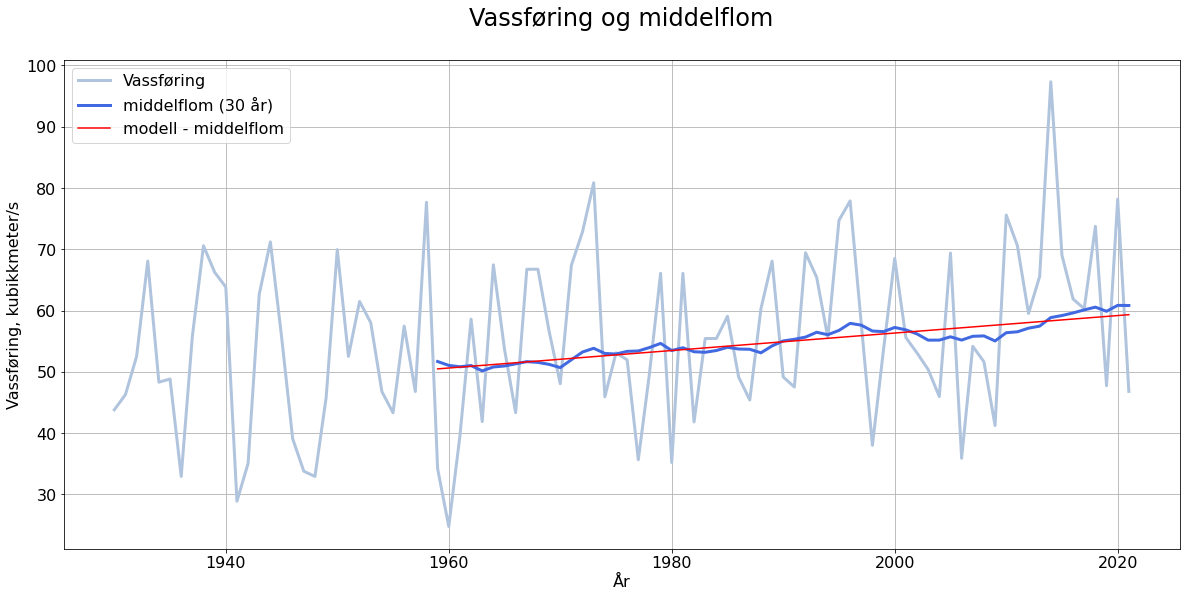

In [8]:
x = np.arange(1959, 2022)

a, b = np.polyfit(x, årleg_maks["middelflom (30 år)"].loc[1959:2021], 1)

def f(x):
    return a*x + b

årleg_maks.plot(
    figsize = (20,9), 
    grid = True, 
    fontsize = 16, 
    linewidth = 3, 
    color = ["lightsteelblue", "royalblue"]
)

plt.plot(
    x, f(x), 
    linewidth = 1.5, 
    label = "modell - middelflom", 
    color = "red"
)

# pynting av plot
plt.title("Vassføring og middelflom\n", fontsize = 24)
plt.legend(fontsize = 16)
plt.ylabel("Vassføring, kubikkmeter/s", fontsize = 16)
plt.xlabel("År", fontsize = 16)
plt.savefig("Reinsnos - årleg maksvassføring og middelflom.png", dpi = 300)
plt.show()

### Ekstrapolasjon - modell for framtidig middelflom

Me kan bruka trendlinja for middelflommen som modell for å seie noko om korleis utviklinga vil vera i åra framover (om utviklinga held fram som no).

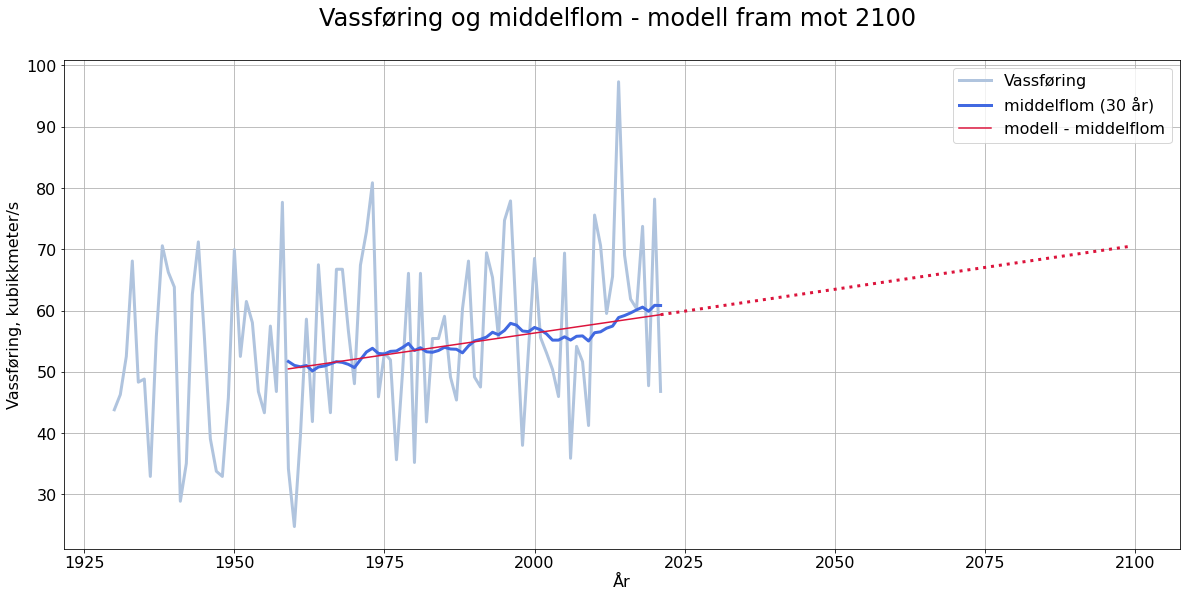

In [9]:
årleg_maks.plot(figsize = (20,9), 
                grid = True, 
                fontsize = 16, 
                linewidth = 3, 
                color = ["lightsteelblue", "royalblue"]
               )

plt.plot(x, f(x), 
         linewidth = 1.5, 
         label = "modell - middelflom", 
         color = "crimson"
        )

# Plottar forlenginga av den lineære modellen
x2 = np.arange(2021, 2100)
plt.plot(x2, f(x2), ":", linewidth = 3, color = "crimson")

# pynting av plot
plt.title("Vassføring og middelflom - modell fram mot 2100 \n", fontsize = 24)
plt.legend(fontsize = 16)
plt.ylabel("Vassføring, kubikkmeter/s", fontsize = 16)
plt.xlabel("År", fontsize = 16)
plt.savefig("Reinsnos - modellering av middelflom 2100.png", dpi = 300)
plt.show()

### Kan sjekka opp mot NVE sine data for flaum

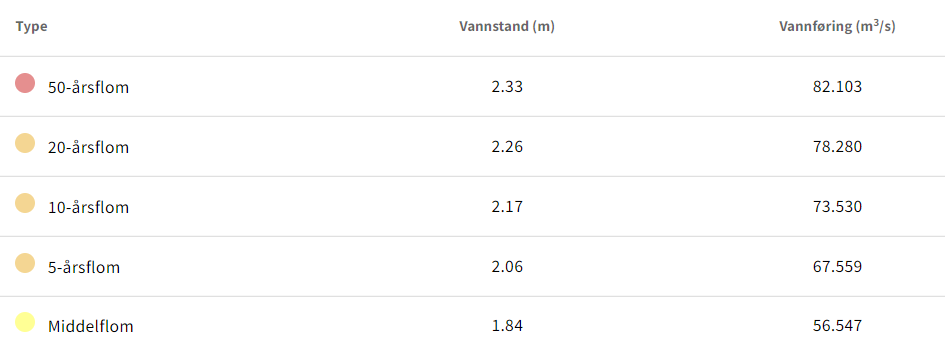

Plottar inn 78.280 som linje, og ser korleis det ser ut. Bruker samme kode som over.

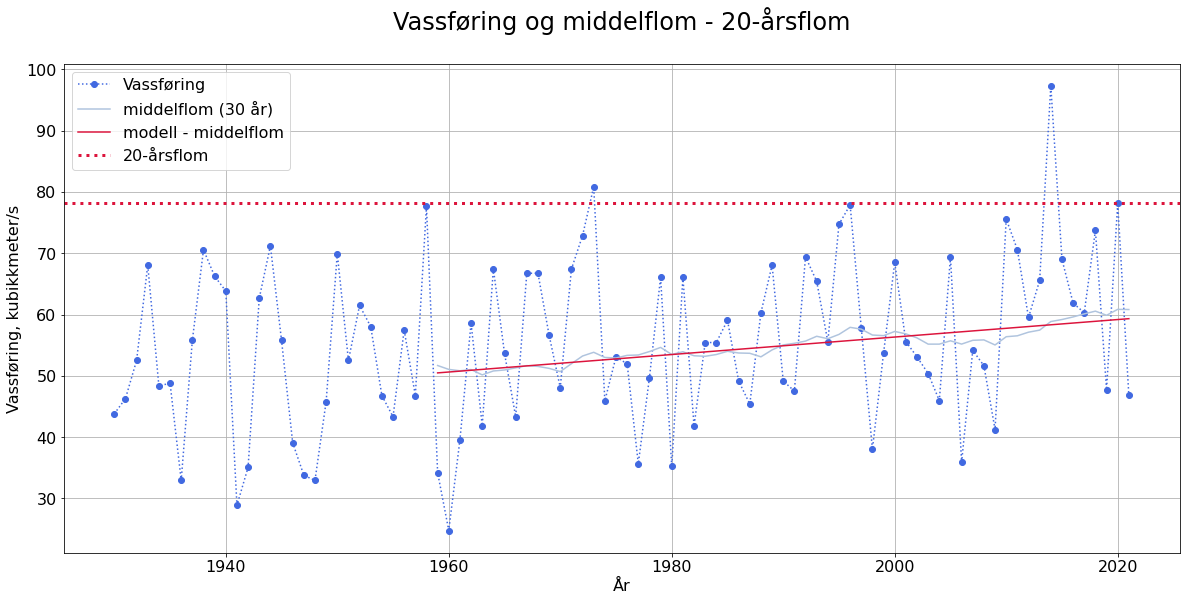

In [10]:
årleg_maks.plot(figsize = (20,9), 
                grid = True, 
                fontsize = 16, 
                linewidth = 1.5, 
                color = ["royalblue", "lightsteelblue"],
                style = ["o:", "-"]
               )

plt.plot(x, f(x), 
         linewidth = 1.5, 
         label = "modell - middelflom", 
         color = "crimson"
        )

# Plottar 20-årsflom
plt.axhline(y = 78.280, 
            color = "crimson", 
            linewidth = 3,
            linestyle = ":", 
            label = "20-årsflom"
           )

# pynting av plot
plt.title("Vassføring og middelflom - 20-årsflom\n", fontsize = 24)
plt.legend(fontsize = 16)
plt.ylabel("Vassføring, kubikkmeter/s", fontsize = 16)
plt.xlabel("År", fontsize = 16)
plt.savefig("Reinsnos - 20årsflom.png", dpi = 300)
plt.show()

## Vassføring per dag

Her ser me på korleis vassføringa har vore på dei ulike dagane i året frå 1917 til 2022. Plottar median, maks- og min, samt 25 og 75 persentilane (som skuggelagt område). 

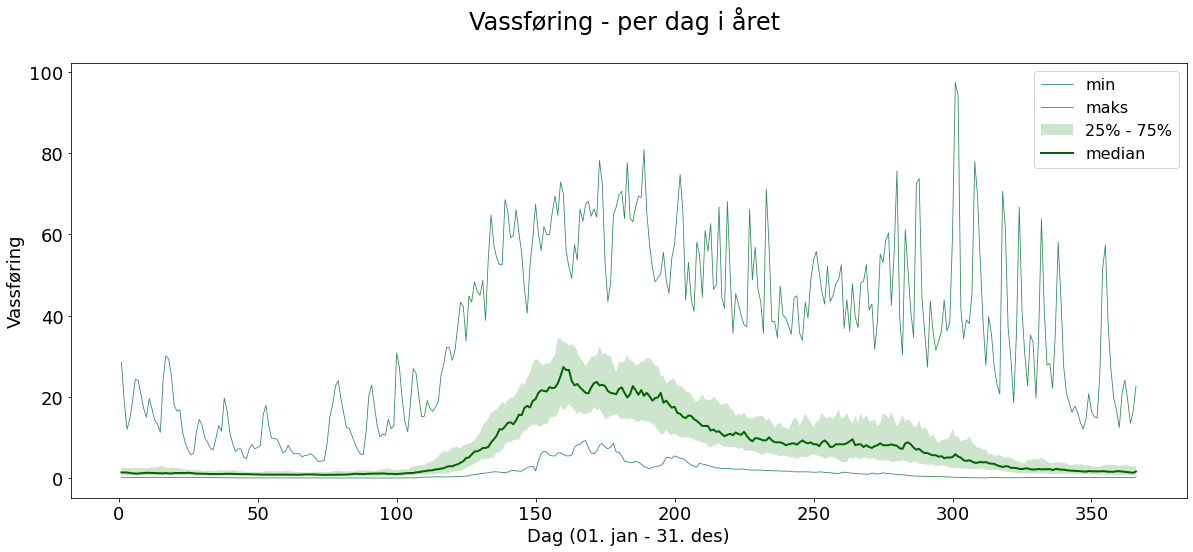

In [11]:
df['doy'] = df.index.dayofyear
df['år'] = df.index.year

# lagar ein pivottabell
piv = pd.pivot_table(df, index=['doy'],columns=['år'], values=['Vassføring'])

# legg til kolonner med dei ulike verdiane
piv["min"] = piv.min(axis = 1)
piv["maks"] = piv.max(axis = 1)
piv["75%"] = piv.quantile(q = 0.75,axis = 1)
piv["median"] = piv.median(axis = 1)
piv["25%"] = piv.quantile(q = 0.25,axis = 1)

# plottar
piv["min"].plot(
    figsize = (20, 8),
    color = "seagreen", 
    linewidth = 0.8, 
    grid = False, 
    fontsize = 18, 
    legend = False
)

piv["maks"].plot(
    color = "seagreen", 
    linewidth = 0.8, 
    grid = False, 
    fontsize = 18, 
    legend = False
)

plt.fill_between(
    piv.index, 
    piv["25%"], piv["75%"], 
    facecolor='green', 
    alpha=0.2, 
    interpolate=True,
    label = "25% - 75%"
)

piv["median"].plot(linewidth = 2, color = "darkgreen")

# pynting
plt.xlabel("Dag (01. jan - 31. des)", fontsize = 18)
plt.ylabel("Vassføring", fontsize = 18)
plt.title("Vassføring - per dag i året \n", fontsize = 24)
plt.legend(fontsize = 16)
plt.savefig("Reinsnos - vassføring per dag gjennom året.png", dpi = 300)
plt.show()